In [1]:
import numpy as np
import scipy
from scipy.signal import butter, lfilter
from scipy.fftpack import fft, fftfreq
from random import randint
import scipy.signal
from scipy import signal
import pandas as pd
import time
from math import sqrt
import xarray as xr
from pprint import pprint
from functools import reduce
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
import math
import pylab
import operator
from sklearn import neighbors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn import metrics, preprocessing 
from sklearn.svm import SVC, SVR
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
sns.set(font_scale=1.2)
import xlwt
from xlrd import open_workbook
from openpyxl import load_workbook
import xlrd
import xlutils
from xlutils.copy import copy

## DATA pre-processing

In [2]:
#import datasets
X_im = np.load('Dataset_12people_60secs_5conds_filrange6and25Hz.npy')[1:,:,:]
X_im_add = np.load('AddDataset_6people_60secs_5conds_filrange6and25Hz.npy')[1:,:,:]
print("Dimesion of dataset: ", X_im.shape)
print("Dimesion of dataset_add: ", X_im_add.shape)
print("'''''Import successfully'''''")

#Combine datasets
X_import = np.concatenate((X_im, X_im_add), axis=1)
print("Dimesion of datasets is: ", X_import.shape)

Dimesion of dataset:  (4, 10, 15000)
Dimesion of dataset_add:  (4, 6, 15000)
'''''Import successfully'''''
Dimesion of datasets is:  (4, 16, 15000)


In [3]:
# Characteristic of the data
num_cond = int(X_import.shape[0]) 
person_num = int(X_import.shape[1])
smp_freq = 250  # 250 Hz
win_len = 3 # 3s  Using sliding window size 3 secs

In [4]:
# sliding window by using size of 3 seconds
len_data = int(X_import.shape[2]/smp_freq) #Find new length data
number_window = int(len_data-win_len+1) 

X_windowed = np.ones((num_cond, person_num, number_window, win_len*smp_freq))

for cond in range(num_cond):
    for p in range(person_num): #number of prople
        for idx in range(number_window): #num of slice
            X_windowed[cond, p, idx, :] = X_import[cond, p, idx*smp_freq:(idx+ win_len) * smp_freq]

print("Dimension of data after used sliding window:", X_windowed.shape)
print("'''''Applied Sliding Window Successfully'''''")

Dimension of data after used sliding window: (4, 16, 58, 750)
'''''Applied Sliding Window Successfully'''''


In [5]:
# # Define window length (4 seconds)
# win = 3 * smp_freq
# freqs, psd = signal.welch(X_windowed[0,0,3,:], smp_freq, nperseg=win)
# freqs2, psd2 = signal.welch(X_windowed[1,0,0,:], smp_freq, nperseg=win)
# freqs3, psd3 = signal.welch(X_windowed[2,0,0,:], smp_freq, nperseg=win)
# # Plot the power spectrum
# sns.set(font_scale=1.2, style='white')
# plt.figure(figsize=(8, 4))
# plt.plot(freqs, psd, color='k', lw=2)
# # plt.plot(freqs2, psd2, color='r', lw=2)
# plt.plot(freqs3, psd3, color='b', lw=2)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power spectral density (V^2 / Hz)')
# plt.ylim([0, psd.max() * 1.1])
# plt.title("Welch's periodogram")
# plt.xlim([0, 26])
# sns.despine()

## Using CCA for frequency recognition

## Experiment Constants

In [6]:
# condition = 1       #1-4 ignore con0
PI = np.pi
sampling_frequency = smp_freq
candidate_frequency = [7.5, 10]
reference_signal_phase = 0
correct_frequency = 7.5
num_harmonic = 3

In [7]:
# Generate Reference Frequency
sin = lambda f, h, t, p: np.sin(2*PI*f*h*t + p)
cos = lambda f, h, t, p: np.cos(2*PI*f*h*t + p)
ref_wave = lambda f, h, t, p: [sin(f, h, t, p), cos(f, h, t, p)]

def generate_reference_signal_at_time(f, t, max_harmonic, phase):
    values = []
    for h in range(1, max_harmonic + 1):
        values += ref_wave(f, h, t, phase)
    return values

def generate_reference_signal(frequency, sampling_frequency, total_time, max_harmonic, phase):
    ref_signal = []
    num_time_step = total_time * sampling_frequency
    for step in range(num_time_step):
        time = step * 1/sampling_frequency
        ref_signal_at_t = generate_reference_signal_at_time(frequency, time, max_harmonic, phase)
        ref_signal.append(ref_signal_at_t)
    return ref_signal

In [8]:
# Solve for Maximum CCA from two multidimensional signal
def find_maximum_canonical_correlations(X, Y):
    if X.shape[0] == Y.shape[0]:
        N = X.shape[0]
    else:
        print('time frame is not equal')
        return None
    C_xx = 1/N * (X.T @ X)
    C_yy = 1/N * (Y.T @ Y)
    C_xy = 1/N * (X.T @ Y)
    C_yx = 1/N * (Y.T @ X)
    C_xx_inv = np.linalg.pinv(C_xx)
    C_yy_inv = np.linalg.pinv(C_yy)
    eig_values, eig_vectors = scipy.linalg.eig(C_yy_inv @ C_yx @ C_xx_inv @ C_xy)
    sqrt_eig_values = np.sqrt(eig_values)
    return max(sqrt_eig_values)

## Generate Reference Signal

*Generate reference signal from candidate frequency upto 6th harmonic*

In [9]:
ref_signal = {}
for frequency in candidate_frequency:
    signal = generate_reference_signal(
            frequency=frequency,
            sampling_frequency=smp_freq,
            total_time=win_len ,
            max_harmonic=num_harmonic,
            phase=reference_signal_phase
    )
    ref_signal[frequency] = pd.DataFrame(signal)

## FBCCA

## FBCCA constant

In [10]:
# # Band Pass Filter Constant
# filter_order = 2
# subband_width = 8
# # add pad frequency to both and high
# PASSBAND_RIPPLE = 0.5
# padding_frequency = 2
# num_subband = 7
# # from paper
# subband_weight_a = 1.25
# subband_weight_b = 0.25

In [11]:
# Band Pass Filter Constant
filter_order = 2
subband_width = 8
# add pad frequency to both and high
PASSBAND_RIPPLE = 100 #0.5 is default
padding_frequency = 2
num_subband = 8
# from paper
subband_weight_a = 1.25
subband_weight_b = 0.25

In [12]:
# Band Filter Input Signal
def filter_signal_verson2(data, low_cutoff_frequency, high_cutoff_frequency):
    low = low_cutoff_frequency
    high = high_cutoff_frequency
    rp = PASSBAND_RIPPLE
    # use Chebyshev Type 1 Filter as described in the Filter Bank paper
    # Ref: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.cheby1.html
    sos = scipy.signal.cheby1(filter_order, rp, [low, high], btype='bandpass', analog=False, fs=sampling_frequency, output='sos')
    # filtfilt has some issued with number precision so we will use
    # SOS (Second-order (biquadratic) IIR digital filtering)
    # view Limitations Section in https://www.mathworks.com/help/signal/ref/cheby1.html
    filtered_signal = scipy.signal.sosfiltfilt(sos, data, axis=0)
    return filtered_signal

In [13]:
def generate_subband_cutoff(subband_type, start_frequency, subband_width, padding_frequency, num_subband):
    # M1
    if subband_type == 'M1':
        return [
            (start_frequency + subband_width * i - padding_frequency,
             start_frequency + subband_width * (i + 1) + padding_frequency)
            for i in range(1,  num_subband + 1)
        ]
    if subband_type == 'M2':
        last_cutoff = start_frequency + subband_width * (num_subband + 1) + padding_frequency
        return [
            (start_frequency + subband_width * i - padding_frequency,
             min(start_frequency + 2 * subband_width * i + padding_frequency, last_cutoff))
            for i in range(1,  num_subband + 1)
        ]
    # M3
    if subband_type == 'M3':
        last_cutoff = start_frequency + subband_width * (num_subband + 1) + padding_frequency
        return [
            (start_frequency + subband_width * i - padding_frequency,
             last_cutoff)
            for i in range(1, num_subband + 1)
        ]

In [14]:
# Sub band signal weight for FBCCA
# optimal a, b from the paper
def subband_weight(n, a=1.25, b=0.25):
    return n ** (-a) + b

In [15]:
def get_subband_weight_vector(num_subband, a=1.25, b=0.25):
    return np.array([subband_weight(n+1, a, b) for n in range(num_subband)])

## FBCCA main program

In [16]:
subbands = generate_subband_cutoff('M3', 0, subband_width, padding_frequency, num_subband)
display(subbands)

[(6, 74), (14, 74), (22, 74), (30, 74), (38, 74), (46, 74), (54, 74), (62, 74)]

In [17]:
def classify_fbcca(data, ref_signal, a, b):
    filtered_signal = {}
    input_signal = data
    for subband in subbands:
        filtered_signal[f"{subband[0]}_{subband[1]}"] = \
            pd.DataFrame(filter_signal_verson2(input_signal, subband[0], subband[1]))
    max_cca = {}

    for subband_key in filtered_signal.keys():
        for ref_signal_key in ref_signal.keys():
            value = find_maximum_canonical_correlations(filtered_signal[subband_key], ref_signal[ref_signal_key])
            if ref_signal_key not in max_cca:
                max_cca[ref_signal_key] = []
            if value.imag == 0.0:
                value = value.real
            if ref_signal_key not in max_cca:
                max_cca[ref_signal_key] = []
            max_cca[ref_signal_key].append(value)
    rho = {}
    for key in max_cca.keys():
        rho[key] = np.array(max_cca[key])
    weight = get_subband_weight_vector(num_subband, a, b)
    result = {}
    for key in rho.keys():
        result[key] = np.sum(weight * rho[key] ** 2)
    result["result"] = max(result.items(), key=operator.itemgetter(1))[0]  
    return result

In [18]:
X_tr_extracted = np.zeros((X_windowed.shape[0], X_windowed.shape[1], X_windowed.shape[2], X_windowed.shape[3])) #11 freq range is interesting
X_tr_FFT_extracted = np.zeros((X_windowed.shape[0], X_windowed.shape[1], X_windowed.shape[2]))
CCA_result = np.zeros((X_windowed.shape[0], X_windowed.shape[1], X_windowed.shape[2]))

for num_con in range(X_windowed.shape[0]):
    for per_idx in range(X_windowed.shape[1]):
        for num_win in range(X_windowed.shape[2]):
            FBCCA_classifier_result = classify_fbcca(X_windowed[num_con, per_idx, num_win], ref_signal,subband_weight_a, subband_weight_b)
            freq_res = FBCCA_classifier_result['result']
            if freq_res == 7.5:
                #CCA performing
                CCA_result[num_con, per_idx, num_win] = 7.5
                
                #Make banpass_filter
                data_used = X_windowed[num_con, per_idx, num_win, :]
                data_filtered = filter_signal_verson2(data_used, 7, 8)
                X_tr_extracted[num_con, per_idx, num_win, :] = data_filtered
                
                #PSD extraction
                win_point = win_len * smp_freq
                freqs, psd = scipy.signal.welch(data_used, smp_freq, nperseg = win_point)
                magnitude = np.abs(psd)[np.where((freqs >= 7.6) & (freqs <=7.7))]
                X_tr_FFT_extracted[num_con, per_idx, num_win] = magnitude
                
            else:
                #CCA performing
                CCA_result[num_con, per_idx, num_win] = 10
                
                #Make banpass_filter
                data_used = X_windowed[num_con, per_idx, num_win, :]
                data_filtered = filter_signal_verson2(data_used, 9.5, 10.5)
                X_tr_extracted[num_con, per_idx, num_win, :] = data_filtered
                
                #PSD extraction
                win_point = win_len * smp_freq
                freqs, psd = scipy.signal.welch(data_used, smp_freq, nperseg = win_point)
#                 magnitude = np.abs(psd)[np.where((freqs >= 7.6) & (freqs <=7.7))]
                magnitude = np.abs(psd)[np.where((freqs == 10))]
                X_tr_FFT_extracted[num_con, per_idx, num_win] = magnitude

print("Done!")    

Done!


In [19]:
print(X_tr_extracted.shape)
print(X_tr_FFT_extracted.shape)

(4, 16, 58, 750)
(4, 16, 58)


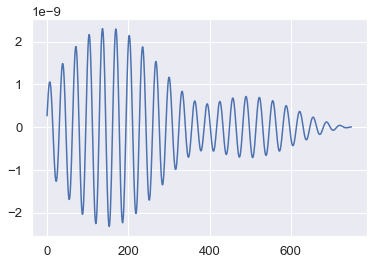

In [20]:
plt.plot(X_tr_extracted[3,10,30,:])
plt.show()

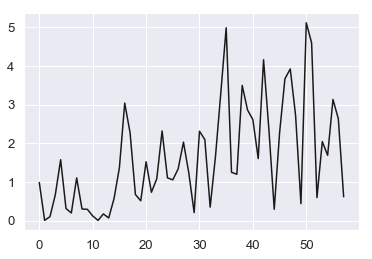

In [21]:
# plt.plot(X_tr_FFT_extracted[3,0,:], 'r')
plt.plot(X_tr_FFT_extracted[3,15,:], 'k')
plt.show()

In [22]:
np.save("Extracted_timeseries_win3.npy", X_tr_extracted)

In [23]:
np.save("PSD_amplitudes_win3.npy", X_tr_FFT_extracted)

In [24]:
np.save("CCA_after_extrated_psd.npy", CCA_result)

In [26]:
for i in range(0,200,10):
    print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
